### Preamble: imports

In [1]:
import random
import glob
import sys
from collections import Counter

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split 

In [3]:
from vggishembed import get_embed

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### In this notebook we'll train a classifier for the top k categories using the kaggle freesound data

In [24]:
files = []
labels = []
with open("train.csv", 'r') as csvfile:
    for i, line in enumerate(csvfile):
        if not i: continue
        filename, label, val = line.split(',')
        if not int(val): continue # this time only pick human-validated samples for training
        labels.append(label)

c = Counter(labels)
print("Number of occurrences of top 10: {}\n".format(c.most_common(10)))
labels = dict([(label[0], i) for i, label in enumerate(c.most_common(10))])
for k,v in list(labels.items()):
    labels[v] = k
print("Labels and their corresponding indices for model: {}\n".format(labels))

# now actually pick files corresponding to these labels
files = []
with open("train.csv", 'r') as csvfile:
    for i, line in enumerate(csvfile):
        if not i: continue
        filename, label, val = line.split(',')
        if val == 0 or label not in labels: continue
        files.append([filename, labels[label]])
print("Sample files: {}".format(files[:10]))

Number of occurrences of top 10: [('Saxophone', 256), ('Violin_or_fiddle', 250), ('Gunshot_or_gunfire', 145), ('Clarinet', 130), ('Flute', 128), ('Cello', 125), ('Telephone', 112), ('Acoustic_guitar', 105), ('Oboe', 99), ('Cowbell', 96)]

Labels and their corresponding indices for model: {0: 'Saxophone', 1: 'Violin_or_fiddle', 2: 'Gunshot_or_gunfire', 3: 'Clarinet', 'Saxophone': 0, 5: 'Cello', 6: 'Telephone', 'Cello': 5, 8: 'Oboe', 'Violin_or_fiddle': 1, 7: 'Acoustic_guitar', 'Acoustic_guitar': 7, 'Flute': 4, 'Clarinet': 3, 'Oboe': 8, 'Telephone': 6, 9: 'Cowbell', 4: 'Flute', 'Cowbell': 9, 'Gunshot_or_gunfire': 2}

Sample files: [['001ca53d.wav', 0], ['00353774.wav', 5], ['003b91e8.wav', 5], ['0048fd00.wav', 2], ['004ad66f.wav', 3], ['0091fc7f.wav', 5], ['00c9e799.wav', 8], ['00cb787c.wav', 4], ['00d3bba3.wav', 6], ['00d9fa61.wav', 4]]


### Reuse the expensive tensorflow session instance

In [26]:
# first run only
try:
    print(sess)
except NameError:
    e,sess = get_embed("./audio_train/%s"%files[0][0], sess=None)

INFO:tensorflow:Restoring parameters from vggish_model.ckpt


### Generate embeddings for the audio files
Some files are too short (shorter than the 0.96 window) and cause an error. We probably don't want them anyway so bypass the files that give an error 

In [27]:
import argparse
from tensorflow import errors

embeds = []
for i, [file, label] in enumerate(files):
    try:
        embeds.append([get_embed("audio_train/%s"%file, sess=sess)[0], np.array([label])]) # positive examples
    # except argparse.ArgumentError or errors.InvalidArgumentError:
    except Exception:
        print("error at file %s"%file, file=sys.stderr, end='\r')
        continue
    print("{:.3f} percent done".format(100*i/len(files)), end='\r')

### Account for any class imbalance

In [40]:
c = Counter(entry[1][0] for entry in embeds)
print(c)

Counter({5: 298, 3: 292, 7: 288, 0: 281, 4: 279, 1: 274, 8: 262, 9: 177, 6: 114, 2: 113})


In [41]:
class_weight = dict([(i, c[0]/c[i]) for i in range(int(len(labels)/2))])
# print("Valid data count, 'Laughter':\t{:>10}\nValid data count, other:\t{:>10}".format(len(positive),len(negative)))
print("Class weights: {c}".format(c=class_weight))

Class weights: {0: 1.0, 1: 1.0255474452554745, 2: 2.4867256637168142, 3: 0.9623287671232876, 4: 1.007168458781362, 5: 0.9429530201342282, 6: 2.4649122807017543, 7: 0.9756944444444444, 8: 1.0725190839694656, 9: 1.5875706214689265}


In [42]:
X_data,Y_data = [*zip(*(embeds))]

In [43]:
maxshape = max(entry.shape[0]+1 for entry in X_data), X_data[0].shape[1]

### To pass variable-length time series data as one train set, pad with zeros

In [44]:
def padnparray(entry=None, shape=maxshape):
    assert entry is not None
    template = np.zeros(shape)
    template[:entry.shape[0],:entry.shape[1]] = entry
    return template
    
X_pad = np.array([padnparray(entry) for entry in X_data])
print("Shape of padded dataset: {sh}".format(sh=X_pad.shape))

Shape of padded dataset: (2378, 32, 128)


### Split data into train (.75) and test (.25) sets

In [108]:
X_train, X_test, Y_train, Y_test = (np.array(arr) for arr in train_test_split(X_pad, Y_data, stratify=Y_data, shuffle=1,
                                                                              train_size=.82))

/home/aalok/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [109]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1949, 32, 128), (1949, 1), (429, 32, 128), (429, 1))

### Keras imports and define model

In [110]:
import keras
import keras.backend as K
from keras.layers import Dense, Dropout, LeakyReLU, Flatten, LSTM, Input, Conv1D, MaxPool1D, Reshape
from keras.models import Model
from keras.metrics import sparse_top_k_categorical_accuracy as top_k
from keras.callbacks import ModelCheckpoint

In [127]:
in_1 = Input(shape=(None,128), name='input_1')
lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=0, name='lstm_1')(in_1)
# lstm = LSTM(64, dropout=0.2, activation='relu', recurrent_dropout=0.2, name='lstm_2', return_sequences=0)(lstm)
dense = Dense(64, activation='relu')(lstm)
dense = Dropout(.2)(dense)
dense = Dense(64, activation='relu')(dense)
dense = Dropout(.2)(dense)
dense = Dense(32, activation='relu')(dense)
dense = Dropout(.2)(dense)
dense = Dense(32, activation='relu')(dense)
out_1 = Dense(len(c), activation='softmax', name='output_1')(dense)

# chkpt = ModelCheckpoint("freesound_laughter_multi.hdf5", save_best_only=1, monitor='val_acc', verbose=1)

def top2(y_true, y_pred):
    return top_k(y_true, y_pred, k=2)

model = Model(inputs=[in_1], outputs=[out_1])
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy", top2])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_80 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_43 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_44 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 32)                2080      
__________

#### A function for when we want to resume training a model using another call to fit() but don't want to lose hist

In [79]:
def appendhist(H,newH):
    for key in H.history.keys():
        H.history[key] += newH.history[key]
    return H

In [128]:
H = model.fit(x=X_train, y=Y_train, shuffle=1, epochs=32, validation_data=(X_test,Y_test), class_weight=class_weight)

Train on 1949 samples, validate on 429 samples
Epoch 1/32
1949/1949 [==============================] - 9s 5ms/step - loss: 2.7033 - sparse_categorical_accuracy: 0.1390 - top2: 0.2437 - val_loss: 2.2350 - val_sparse_categorical_accuracy: 0.1865 - val_top2: 0.3170
Epoch 2/32
1949/1949 [==============================] - 4s 2ms/step - loss: 2.6661 - sparse_categorical_accuracy: 0.1750 - top2: 0.3145 - val_loss: 2.1803 - val_sparse_categorical_accuracy: 0.1935 - val_top2: 0.3170
Epoch 3/32
1949/1949 [==============================] - 4s 2ms/step - loss: 2.6126 - sparse_categorical_accuracy: 0.1950 - top2: 0.3381 - val_loss: 2.1631 - val_sparse_categorical_accuracy: 0.1841 - val_top2: 0.3613
Epoch 4/32
1949/1949 [==============================] - 4s 2ms/step - loss: 2.5778 - sparse_categorical_accuracy: 0.2052 - top2: 0.3525 - val_loss: 2.1104 - val_sparse_categorical_accuracy: 0.2121 - val_top2: 0.4103
Epoch 5/32
1949/1949 [==============================] - 4s 2ms/step - loss: 2.5577 - spar

### Visualize history

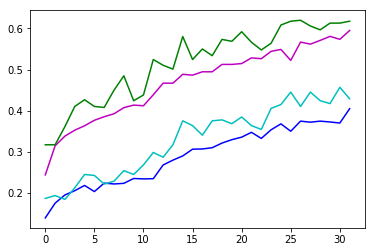

In [129]:
plt.plot(range(len(H.history['loss'])), H.history['sparse_categorical_accuracy'], 'b-', H.history['top2'], 'm-',
         H.history['val_sparse_categorical_accuracy'], 'c-', H.history['val_top2'], 'g-',
        )#H.history['loss'], 'b-.', H.history['val_loss'], 'c-.')
plt.show()

### Evaluate model on validation data

In [144]:
E = model.evaluate(x=X_test, y=Y_test)
print("eval loss: {:>7.7f}, eval acc: {:>7.7f}, eval top2 acc: {:>7.5f}".format(*E))

429/429 [==============================] - 0s 604us/step
eval loss: 1.5462535, eval acc: 0.4289044, eval top2 acc: 0.61772


### More training

In [147]:
appendhist(H, model.fit(x=X_train, y=Y_train, shuffle=1, epochs=64, validation_data=(X_test,Y_test), class_weight=class_weight))

Train on 1949 samples, validate on 429 samples
Epoch 1/64
1949/1949 [==============================] - 4s 2ms/step - loss: 1.5249 - sparse_categorical_accuracy: 0.5162 - top2: 0.7255 - val_loss: 1.1574 - val_sparse_categorical_accuracy: 0.5828 - val_top2: 0.7692
Epoch 2/64
1949/1949 [==============================] - 4s 2ms/step - loss: 1.5436 - sparse_categorical_accuracy: 0.5254 - top2: 0.7317 - val_loss: 1.1734 - val_sparse_categorical_accuracy: 0.6270 - val_top2: 0.7622
Epoch 3/64
1949/1949 [==============================] - 4s 2ms/step - loss: 1.5265 - sparse_categorical_accuracy: 0.5249 - top2: 0.7219 - val_loss: 1.1624 - val_sparse_categorical_accuracy: 0.6061 - val_top2: 0.7832
Epoch 4/64
1949/1949 [==============================] - 4s 2ms/step - loss: 1.4905 - sparse_categorical_accuracy: 0.5428 - top2: 0.7414 - val_loss: 1.1384 - val_sparse_categorical_accuracy: 0.6107 - val_top2: 0.7902
Epoch 5/64
1949/1949 [==============================] - 4s 2ms/step - loss: 1.5576 - spar

1949/1949 [==============================] - 4s 2ms/step - loss: 1.4137 - sparse_categorical_accuracy: 0.5844 - top2: 0.7599 - val_loss: 1.1047 - val_sparse_categorical_accuracy: 0.5944 - val_top2: 0.7995
Epoch 39/64
1949/1949 [==============================] - 4s 2ms/step - loss: 1.4275 - sparse_categorical_accuracy: 0.5757 - top2: 0.7568 - val_loss: 0.9986 - val_sparse_categorical_accuracy: 0.6387 - val_top2: 0.8159
Epoch 40/64
1949/1949 [==============================] - 4s 2ms/step - loss: 1.4124 - sparse_categorical_accuracy: 0.5772 - top2: 0.7583 - val_loss: 1.0643 - val_sparse_categorical_accuracy: 0.6340 - val_top2: 0.8182
Epoch 41/64
1949/1949 [==============================] - 4s 2ms/step - loss: 1.4024 - sparse_categorical_accuracy: 0.5685 - top2: 0.7589 - val_loss: 0.9907 - val_sparse_categorical_accuracy: 0.6667 - val_top2: 0.8345
Epoch 42/64
1949/1949 [==============================] - 4s 2ms/step - loss: 1.4689 - sparse_categorical_accuracy: 0.5752 - top2: 0.7604 - val_l

### Updated visualization

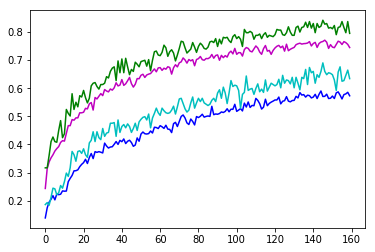

In [152]:
plt.plot(range(len(H.history['loss'])), H.history['sparse_categorical_accuracy'], 'b-', H.history['top2'], 'm-',
         H.history['val_sparse_categorical_accuracy'], 'c-', H.history['val_top2'], 'g-')
plt.show()

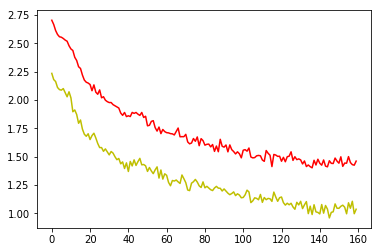

In [162]:
plt.plot(range(len(H.history['loss'])), H.history['loss'], 'r-', H.history['val_loss'], 'y-')
plt.show()

### Evaluate model on validation data

In [149]:
E = model.evaluate(x=X_test, y=Y_test)
print("eval loss: {:>7.7f}, eval acc: {:>7.7f}, eval top2 acc: {:>7.5f}".format(*E))

429/429 [==============================] - 0s 607us/step
eval loss: 1.0373852, eval acc: 0.6340326, eval top2 acc: 0.79487


### Sanity check: look at sample predictions

In [191]:
s = slice(16,32)
out = ["true: {:<20}|\tpred_1: {:<20} pred_2: {:<20}".format(labels[ytrue],labels[np.argpartition(ypred,-2)[-2:][0]],
                                                             labels[np.argpartition(ypred,-2)[-2:][1]]) 
       for ypred,[ytrue] in zip(model.predict(x=X_test[s]), Y_test[s])]
for line in out: print(line)

true: Flute               |	pred_1: Saxophone            pred_2: Clarinet            
true: Acoustic_guitar     |	pred_1: Cello                pred_2: Acoustic_guitar     
true: Flute               |	pred_1: Clarinet             pred_2: Flute               
true: Oboe                |	pred_1: Violin_or_fiddle     pred_2: Cello               
true: Cowbell             |	pred_1: Violin_or_fiddle     pred_2: Cowbell             
true: Violin_or_fiddle    |	pred_1: Telephone            pred_2: Cello               
true: Saxophone           |	pred_1: Violin_or_fiddle     pred_2: Cello               
true: Acoustic_guitar     |	pred_1: Cello                pred_2: Acoustic_guitar     
true: Acoustic_guitar     |	pred_1: Cello                pred_2: Acoustic_guitar     
true: Cowbell             |	pred_1: Violin_or_fiddle     pred_2: Cowbell             
true: Acoustic_guitar     |	pred_1: Acoustic_guitar      pred_2: Cello               
true: Flute               |	pred_1: Clarinet          